### Opacity Correction in Outflows

To do a velocity-dependent opacity correction, the first choice to make is what pixels to select for a calculating the average ratio between the 12co and 13co spectra. Zhang et al. (2016) select only the pixels in the area covered by the outflow, with both 12 and 13co detected to 5 sigma. I think the 5 sigma is probably overkill.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics import *

In [2]:
c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
t_hops = Table.read("../../catalogs/hops.fits")
hops_169 = t_hops[t_hops["HOPS"] == 169][0]
coord = SkyCoord(hops_169["RAJ2000"], hops_169["DEJ2000"], unit=u.deg)
width=height=4*u.arcmin
vmin, vmax = -2*u.km/u.s, 4.7*u.km/u.s
sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                      region_kwargs=dict(center=coord, width=width, height=height))
sub13 = extract_subcube(c13, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))
rms12 = rms(sub12[:,:,:40], velocity_range=[[-2,0],[18,20]]*u.km/u.s)
rms13 = rms(sub13[:,:,:40], velocity_range=[[0,2], [16,18]]*u.km/u.s)
print(rms12, rms13)

0.8646953701972961 K 0.38636189699172974 K


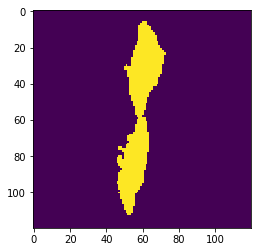

In [3]:
mask12_3sig = (sub12 > 3*rms12)
mask13_3sig = (sub13 > 3*rms13)
blue_vel = 4.7*u.km/u.s
red_vel = 10*u.km/u.s
red12 = sub12.spectral_slab(red_vel, 20*u.km/u.s)
blue12 = sub12.spectral_slab(-2*u.km/u.s, blue_vel)
red12mom0, blue12mom0 = red12.moment0(), blue12.moment0()
red12mom0_gt_10sig, blue12mom0_gt_10sig = (red12mom0 > 10*sigma_mom0(red12, rms12)), (blue12mom0 > 10*sigma_mom0(blue12, rms12))
x,y = np.indices(red12mom0.shape)[1], np.indices(red12mom0.shape)[0]
mask_outflow = (red12mom0_gt_10sig | blue12mom0_gt_10sig) & (x < 80)
np.save("mask_outflow", mask_outflow)
plt.imshow(mask_outflow)

<Gaussian1D(amplitude=1., mean=7000., stddev=1.)>

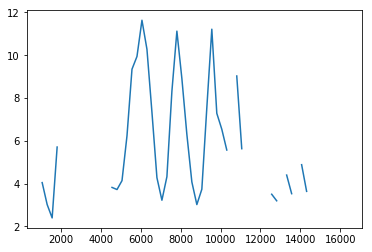

In [4]:
sub12_ratiomask = sub12.with_mask(mask_outflow).with_mask(mask12_3sig).with_mask(mask13_3sig)
sub13_ratiomask = sub13.with_mask(mask_outflow).with_mask(mask13_3sig).with_mask(mask12_3sig)
# sub12_ratiomask = sub12.with_mask(mask12_3sig).with_mask(mask13_3sig)
# sub13_ratiomask = sub13.with_mask(mask13_3sig).with_mask(mask12_3sig)
ratio = sub12_ratiomask / sub13_ratiomask

# ratio_rms = ratio * np.sqrt((rms12 / sub12_ratiomask) ** 2. + (rms13 / sub13_ratiomask) ** 2.)
# print(ratio_rms)
# print(np.isnan(ratio))
ratio_spec = ratio.mean((1,2))
x, y = ratio_spec.spectral_axis.value, ratio_spec.value
plt.plot(x,y)
fit_gaussian(x, y, gaussian_kwargs=dict(mean=7000, fixed={'mean':True}))

<ErrorbarContainer object of 3 artists>

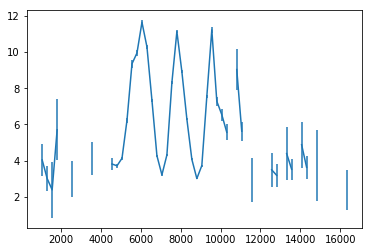

In [5]:
ratio_samples = np.count_nonzero(~ratio.apply_numpy_function(np.isnan), (1,2))
plt.errorbar(ratio_spec.spectral_axis.value, ratio_spec.value, yerr=np.sqrt((ratio_spec / ratio_samples)))

In [6]:
# ratio_rms = ratio * np.sqrt((rms12 / sub12_ratiomask) ** 2. + (rms13 / sub13_ratiomask) ** 2.)

In [7]:
ratio_rms = ratio * ((sub12_ratiomask / rms12 )**-2 + (sub13_ratiomask / rms13) **-2) ** 0.5
ratio_weight = ratio_rms ** -2
ratio_weighted = ratio * ratio_weight

[      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 3.5174727 2.9654639
 2.3933978 5.7053275       nan       nan 2.9776013       nan       nan
       nan 4.103755        nan       nan       nan 3.3947475 2.5586166
 2.30255   3.6436615 7.9984245 8.187742  9.335365  7.052285  4.7632666
 3.054861  2.4656518 3.2013133 5.7911243 7.825885  7.1577086 3.7774565
 2.7917736 2.5252676 2.882148  5.2476625 9.6450615 6.417926  6.071234
 3.986171        nan 8.798244  3.0333698       nan 2.9459245       nan
       nan       nan 3.2897882 2.857991        nan 4.349654  3.259405
       nan 4.7542515 3.5361886       nan 3.738637        nan       nan
       nan       nan       nan 2.362545        nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan] [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan      

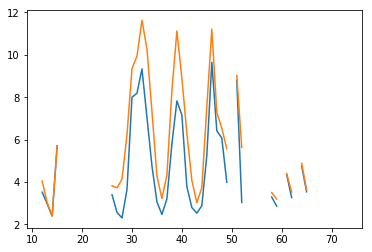

In [8]:
ratio_weightmean = ratio_weighted.sum((1,2)) / ratio_weight.sum((1,2))
ratio_unweightmean = ratio.mean((1,2))
print(ratio_weightmean, ratio_unweightmean)

plt.plot(ratio_weightmean)
plt.plot(ratio_unweightmean)

In [9]:
def average_spectrum(cube, axis=(1,2), weights=None, ignore_nan=True,
                    return_std=True):
    """
    Calculate the (weighted) average spectrum in a spectral cube
    Optionally calculate and return the (weighted) standard deviation
    spectrum. `weights` should be a cube/numpy array with the same shape as `cube`
    `axis` denotes the axis/axes to average over. For a standard SpectralCube,
    the two spatial axes are (1,2).
    Returns
    -------
    average_spectrum : 1D array_like
    std_spectrum: 1D array_like, optional
    """
    
    if weights:
        spec_mean = (cube * weights).sum(axis) / weights.sum(axis)
    else:
        spec_mean = cube.mean(axis)
#     except np.AxisError:
#         #Weight is a 2D array
#         spec_mean = weighted_cube.sum(axis) / weights.nansum()
#     except AttributeError:
#         #Weight is a constant value.
#         spec_mean = weighted_cube.sum(axis) / weights
    
    if return_std:
        if weights:
            resids = (cube - spec_mean[:, np.newaxis, np.newaxis])**2.
            spec_std = ((resids * weights).sum(axis) / weights.sum(axis)) ** 0.5
        else:
            spec_std = cube.std(axis)
        
        return spec_mean, spec_std
    else:
        return spec_mean


<ErrorbarContainer object of 3 artists>

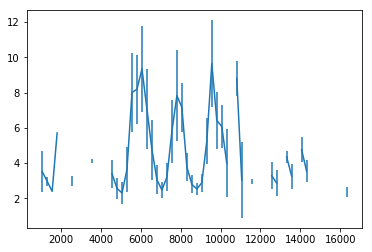

In [10]:
ratiospec, ratiospec_std = average_spectrum(ratio, weights=ratio_weight)
plt.errorbar(ratiospec.spectral_axis.value, ratiospec.value, yerr=ratiospec_std.value)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
           c0         c1  c2
    ---------------- --- ---
    2.61527239898417 0.0 1.0 Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0           c1           c2         
                       s / m       s2 / m2       
    ------------------ ----- --------------------
    2.5278653812129335   0.0 8.49398803785944e-06
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                 c1                   c2         
                             s / m               s2 / m2       
    ----------------- -------------------- --------------------
    418.7332792363254 -0.11891583253003216 8.49398803785944e-06


(0, 20)

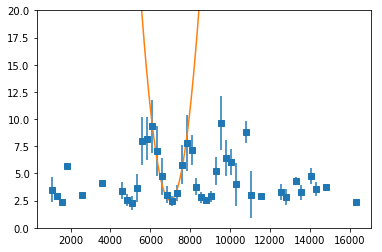

In [11]:
from astropy.modeling.polynomial import Polynomial1D
import astropy.modeling.fitting
vsys = 7000.
def tiedfunc(poly, vsys=7000.):
    c1 = -2*vsys*poly.c2
    return c1
# p_init = Polynomial1D(2, c0=3, c1=0, c2=0, fixed={'c1':True})


def fit_parabola(x, y, x_shift=0., fit_xrange=None, autoguess=True,
                poly_kwargs={},
                fitfunc=fitting.LinearLSQFitter,
                weights=None,
                fit_kwargs={},
                shift_back=True):
    if autoguess:
        poly_kwargs.update(
            dict(c0 = np.interp(x_shift, x, y), c1 = 0, c2 = 1, fixed={'c1':True}))
    p_init = Polynomial1D(2, **poly_kwargs)
    fitter = fitfunc()
    p_fit = fitter(p_init, x - x_shift, y, weights=weights, **fit_kwargs)
    print(p_init, p_fit)
    if shift_back:
        p_shiftback = p_fit.copy()
        p_shiftback.c0 = p_fit.c0 - p_fit.c1*x_shift + p_fit.c2*x_shift**2.
        p_shiftback.c1 = p_fit.c1 - 2*p_fit.c2*x_shift
        p_shiftback.c2 = p_fit.c2
        return p_shiftback
    else:   
        return p_fit

    
x, y = (ratiospec.spectral_axis), ratiospec
ii_fit = ((x > 6000*u.m/u.s) & (x < 8000*u.m/u.s))
# fitter = fitting.LinearLSQFitter()
# p_fit = fitter(p_init, x[ii_fit], y[ii_fit], weights=1/ratiospec_std.value[ii_fit])
# param_cov = fitter.fit_info['param_cov']
# print(param_cov)

p_fit2 = fit_parabola(x[ii_fit], y[ii_fit], x_shift=7000.*u.m/u.s, 
                      autoguess=True, weights=1/ratiospec_std[ii_fit],
                      shift_back=True)

print(p_fit2)

plt.errorbar(x.value, y.value, yerr=ratiospec_std.value, marker='s', ls='')
# plt.plot(np.linspace(-1000,1000)+7000, p_fit2(np.linspace(-1000,1000)*u.m/u.s))
plt.plot(np.linspace(5e3,1e4), p_fit2(np.linspace(5e3,1e4)*u.m/u.s))
plt.axhline(62)
plt.ylim(0,20)

# 62/p_fit2(4700)

Fitting a parabola to the above spectrum, we fit the equation:

$\frac{ T_{12} }{ T_{13} } = c_0 + c_1 (v - v_{sys}) + c_2 (v - v_{sys})^2$.

Following Zhang et al. (2016), this parabola is constrained to reach a minimum at the system velocity, $v_{sys}$ which in this case comes from a Gaussian fit to the average C18O spectrum, and is found to be 7000 m/s. To make things easier, we'll shift the spectrum so that the system velocity is at 0. So, the derivative of the above parabola should be zero at $v = v_{sys}$.

$\frac {d \frac{ T_{12} }{ T_{13} }}{d (v - v_{sys})}|_{v = v_{sys}} = 0 = c_1 + 2 c_2 (v - v_{sys}) = c_1 = 0$.

Thus,

$\frac{ T_{12} }{ T_{13} } = c_0 + c_2 (v - v_{sys})^2$.

Our guess for the y-offset of the parabola ($c_0$) will then be the value at $v_{sys}$, which can we can estimate by interpolating the spectrum to that point.

Fix $c_1 = 0$, guess $c_0 = \frac{ T_{12} }{ T_{13} } (v = v_{sys})$, and constrain $c_2 > 0$. 

Then, to translate the resulting function back to the original velocity frame, multiply out the shifted parabola:

$\frac{ T_{12} }{ T_{13} } = c_0 + c_1 v - c_1 v_{sys} - 2 c_2 v v_{sys} + c_2 v^2 + c_2 v_{sys}^2$.

$ = (c_0 - c_1 v_{sys} + c_2 v_{sys}^2) + v (c_1 - 2 c_2 v_{sys}) + c_2 v^2$.

Thus, to shift the parabola back, the new parameters are:
$c_0' = c_0 - c_1 v_{sys} + c_2 v_{sys}^2,~c_1' = c_1 - 2 c_2 v_{sys},~c_2' = c_2$



### Fitting one or Multiple Gaussians instead of parabola.

In [12]:
print(y)
g = fit_gaussian(x, y, n_models=2, gaussian_kwargs=dict(
    amplitude=[-10,-10]*u.dimensionless_unscaled, mean=[7000,9000]*u.m/u.s, stddev=[1000,1000]*u.m/u.s))

[      nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan 3.5174727 2.9654639
 2.3933978 5.7053275       nan       nan 2.9776013       nan       nan
       nan 4.103755        nan       nan       nan 3.3947475 2.5586166
 2.30255   3.6436615 7.9984245 8.187742  9.335365  7.052285  4.7632666
 3.054861  2.4656518 3.2013133 5.7911243 7.825885  7.1577086 3.7774565
 2.7917736 2.5252676 2.882148  5.2476625 9.6450615 6.417926  6.071234
 3.986171        nan 8.798244  3.0333698       nan 2.9459245       nan
       nan       nan 3.2897882 2.857991        nan 4.349654  3.259405
       nan 4.7542515 3.5361886       nan 3.738637        nan       nan
       nan       nan       nan 2.362545        nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan]


(86,) (86,) (86,)
[ 7.24754102e+03 -3.78333400e+00  7.36176819e-04 -6.32457673e-08
  2.02424715e-12] (15,)


<Polynomial1D(4, c0=7247.54102219, c1=-3.783334, c2=0.00073618, c3=-0.00000006, c4=0.)>

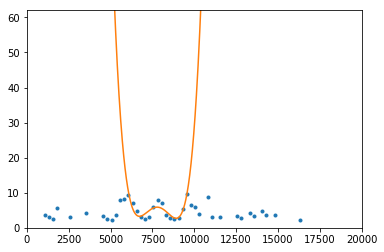

In [13]:
ii_fit2 = (x > 6*u.km/u.s) & (x < 9.8*u.km/u.s)
print(x.shape, y.shape, ratiospec_std.shape)

def tiedfunc_c1(p4, vmin=7000):
    return -(2*p4.c2*vmin + 3*p4.c3*vmin**2 + 4*p4.c4*vmin**3)
def tiedfunc_c2(p4, vmin=9000):
    return -(p4.c1 + 3*p4.c3*vmin**2 + 4*p4.c4*vmin**3)/(2*vmin)

p4_init = models.Polynomial1D(4, c0=7200, c1=-3.7, c2=0.0007, c3=0, c4=0)#, tied=dict(c1=tiedfunc_c1, c2=tiedfunc_c2))
fitter = fitting.LevMarLSQFitter()
p4_fit = fitter(p4_init, x[ii_fit2].value, y[ii_fit2].value)#, weights=1/ratiospec_std[ii_fit2])
print(p4_fit.parameters, ratiospec_std[ii_fit2].shape)
plt.plot(x.value, y.value, '.')
plt.plot(np.linspace(0,20000,1000), p4_fit(np.linspace(0,2e4,1e3)))
plt.ylim(0,62)
plt.xlim(0,2e4)
p4_fit

In [14]:
vmin = 8800
p4_fit.parameters[1] + 2*p4_fit.parameters[2]*vmin + 3*p4_fit.parameters[3]*vmin**2 + 4*p4_fit.parameters[4]*vmin**3.

-0.0020076378111681947

In [15]:
p4_fit.parameters

array([ 7.24754102e+03, -3.78333400e+00,  7.36176819e-04, -6.32457673e-08,
        2.02424715e-12])

[ 7.24752013e+03 -3.78332310e+00  7.36174703e-04 -6.32455863e-08
  2.02424139e-12] 28.587012615917047


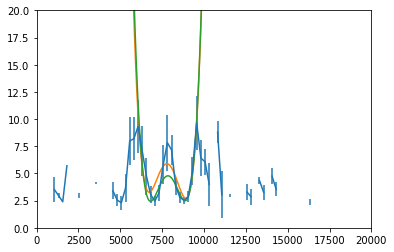

In [16]:
from scipy.optimize import curve_fit
def p4(x, c0, c1, c2, c3, c4):
    return c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4
popt, pcov = curve_fit(p4, x.value[ii_fit2], y.value[ii_fit2])#, sigma=ratiospec_std[ii_fit2])
popt_w, pcov_w = curve_fit(p4, x.value[ii_fit2], y.value[ii_fit2], sigma=ratiospec_std[ii_fit2])
plt.errorbar(x.value, y.value, yerr=ratiospec_std)
plt.plot(np.linspace(0,20000,1000), p4(np.linspace(0,2e4,1e3), *popt))
plt.plot(np.linspace(0,20000,1000), p4(np.linspace(0,2e4,1e3), *popt_w))
plt.ylim(0,20)
plt.xlim(0,2e4)
print(popt, p4(10e3, *popt))

In [17]:
p = np.poly1d(np.flip(popt))

In [18]:
p.deriv().roots

array([8917.98130126, 7784.40580477, 6730.68265327])

$f' = A(v - v_{sys,1})(v - v_{sys,2})(v_{max} - v)$

$f' = A(v^2 - vv_{sys,1} - vv_{sys,2} + v_{sys,1}v_{sys,2})(v_{max} - v)$

$f' = A(-v^3 + v^2(v_{max} + v_{sys,1} + v_{sys,2}) + v(-v_{sys,1}v_{max} - v_{sys,2}v_{max} - v_{sys,1}v_{sys,2}) + v_{sys,1}v_{sys,2}v_{max})$

$f = \int f' dv = A(-\frac{v^4}{4} + \frac{v^3}{3}(v_{max} + v_{sys,1} + v_{sys,2})
+ \frac{v^2}{2}(-v_{sys,1}v_{max} - v_{sys,2}v_{max} - v_{sys,1}v_{sys,2}) + v(v_{sys,1}v_{sys,2}v_{max})) + B$

Thus, the polynomial coefficients are:

$c_0 = B$

$c_1 = Av_{sys,1}v_{sys,2}v_{max}$

$c_2 = -\frac{A}{2}(v_{sys,1}v_{max} + v_{sys,2}v_{max} + v_{sys,1}v_{sys,2})$

$c_3 = \frac{A}{3}(v_{max} + v_{sys,1} + v_{sys,2})$

$c_4 = -\frac{A}{4}$.

There are 2 quantities I'd like to fix, $v_{sys,1}$ and $v_{sys,2}$, and 3 unknowns to fit: $A$, $B$, and $v_{max}$. Replace all instances of A with $-4c_4$:

$c_1 = -4c_4v_{sys,1}v_{sys,2}v_{max}$

$v_{max} = -\frac{c_1}{4c_4v_{sys,1}v_{sys,2}}$



<function fit_poly4.<locals>.<lambda> at 0x14e04d38c8>


(5000.0, 10000.0)

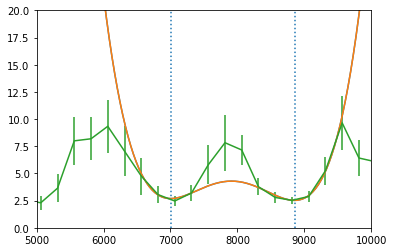

In [26]:
def p4_vsys(x, c0, c1, c4, v_sys1, v_sys2):
    v_max = -c1/(4*c4*v_sys1*v_sys2)
#     print(v_max)
    c2 = 2*c4*(v_sys1*v_max + v_sys2*v_max + v_sys1*v_sys2)
    c3 = -(4./3)*c4*(v_max + v_sys1 + v_sys2)
    return c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4

v_sys1, v_sys2 = 7003., 8852.

def p4_vsys_fixed(x, c0, c1, c4):
    return p4_vsys(x, c0, c1, c4, v_sys1, v_sys2)

# plt.ylim(-100,100)
# plt.plot(np.linspace(0,2e4,1000), 
#          p4_constrain(np.linspace(0,2e4,1000),
#                       7.24754102e+03, -3.783334, 2.0424715e-12))
ii_fit2 = (x > 6.2*u.km/u.s) & (x < 9.5*u.km/u.s)
popt, pcov = curve_fit(p4_vsys_fixed, x.value[ii_fit2], y.value[ii_fit2], maxfev=100000
                      , method='lm', sigma=ratiospec_std[ii_fit2])
p4_fit2 = fit_poly4(x.value[ii_fit2], y.value[ii_fit2], sigma=ratiospec_std[ii_fit2],
                   fix_minima=[7003., 8852.])
print(p4_fit2)
xgrid = np.linspace(0,2e4,1e3)
p4_fit_clip62 = p4_vsys_fixed(xgrid, *popt).clip(0,62)
p4_fit2_clip62 = p4_fit2(xgrid).clip(0,62)
# np.clip?
# print(p4_fit_clip62)

plt.plot(xgrid, p4_fit_clip62)
plt.plot(xgrid, p4_fit2_clip62)
plt.errorbar(x.value, y.value, yerr=ratiospec_std)
plt.axvline(v_sys1, ls=":")
plt.axvline(v_sys2, ls=":")
p4_vsys_fixed(x.value[ii_fit2], *popt)
plt.ylim(0,20)
plt.xlim(5e3,10e3)

# plt.plot(x.value[ii_fit2], p4_constrain(x.value[ii_fit2], v_sys1=7003, v_sys2=8852, *popt))
# p4_vsys.c0
